<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Syngine</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Using Syngine with ObsPy</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))

---

This is a quick tutorial on how to use the Syngine service with ObsPy. Further information:

* [IRIS Syngine Service](http://ds.iris.edu/ds/products/syngine/)
* [Documentation of the ObsPy Syngine Client](http://docs.obspy.org/packages/obspy.clients.syngine.html)

In [1]:
# First a bit of setup to make the plots appear in the
# notebook and make them look a bit nicer.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

Import ObsPy and its FDSN client used to download real data.

In [2]:
import obspy
from obspy.clients.fdsn import Client

# Create a client instance connected to IRIS.
c = Client("IRIS")

This example deals with a deep event so we expect a very clear first P arrival and weak surface waves.

#### (Optional) Acquire Event Information

Event depth in km: 582.1


/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/obspy/imaging/maps.py:45: UserWarning: basemap/pyproj with proj4 version >= 5 has a bug that results in inverted map axes. Your maps may be wrong. Please use another version of proj4, or use cartopy.
  warnings.warn(msg)


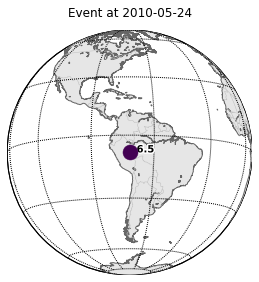

In [3]:
cat = c.get_events(starttime=obspy.UTCDateTime(2010, 5, 24, 16),
                   endtime=obspy.UTCDateTime(2010, 5, 24, 17),
                   minmagnitude=6.4)
print("Event depth in km:", cat[0].origins[0].depth / 1000.0)
cat.plot(projection="ortho");

#### Download Observed Data

We will now use the FDSN client to download the observed data as well as the instrument response.

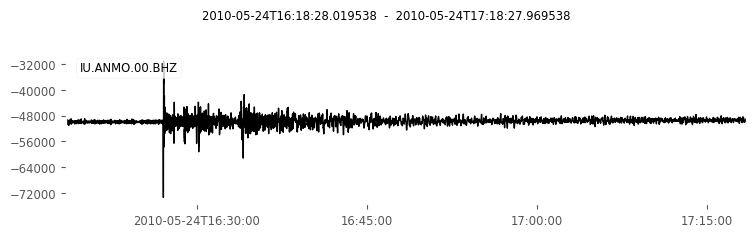

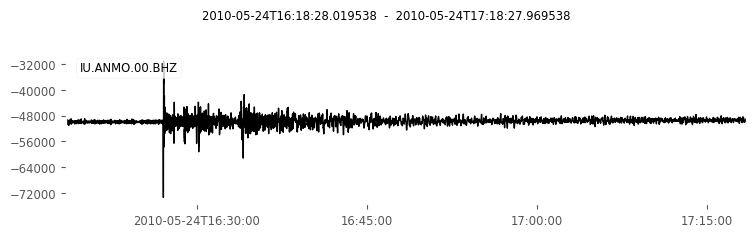

In [4]:
# The `attach_response` argument will cause a second request to the
# station service which fetches the instrument response.
st = c.get_waveforms(network="IU", station="ANMO", location="00", channel="BHZ",
                     starttime=obspy.UTCDateTime(2010, 5, 24, 16, 18, 28),
                     endtime=obspy.UTCDateTime(2010, 5, 24, 17, 18, 28),
                     attach_response=True)
st.plot()

The next step is to convert it to physical units. The pre filter here is very wide but it is a very good station so that is ok here.

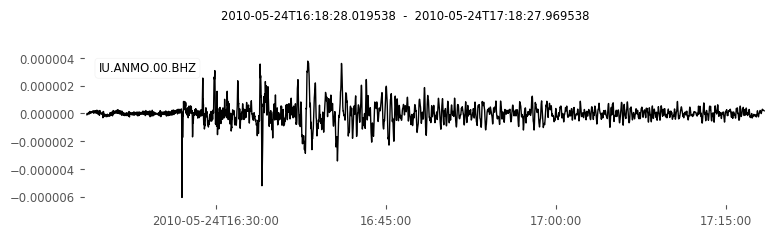

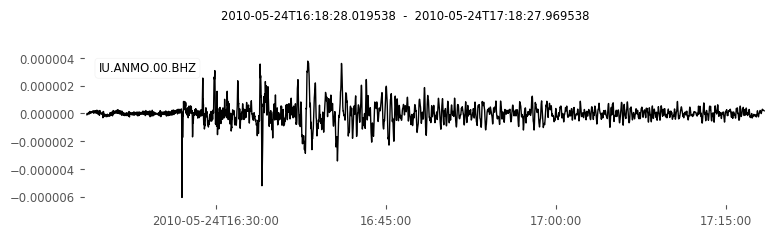

In [5]:
st.remove_response(output="DISP", pre_filt=(0.005, 0.01, 4, 8))
st.plot()

#### Plot a map of the receiver we want to use

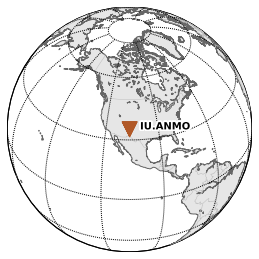

In [6]:
c.get_stations(network="IU", station="ANMO", level="station").plot("ortho");

#### Download Synthetic Data From Syngine

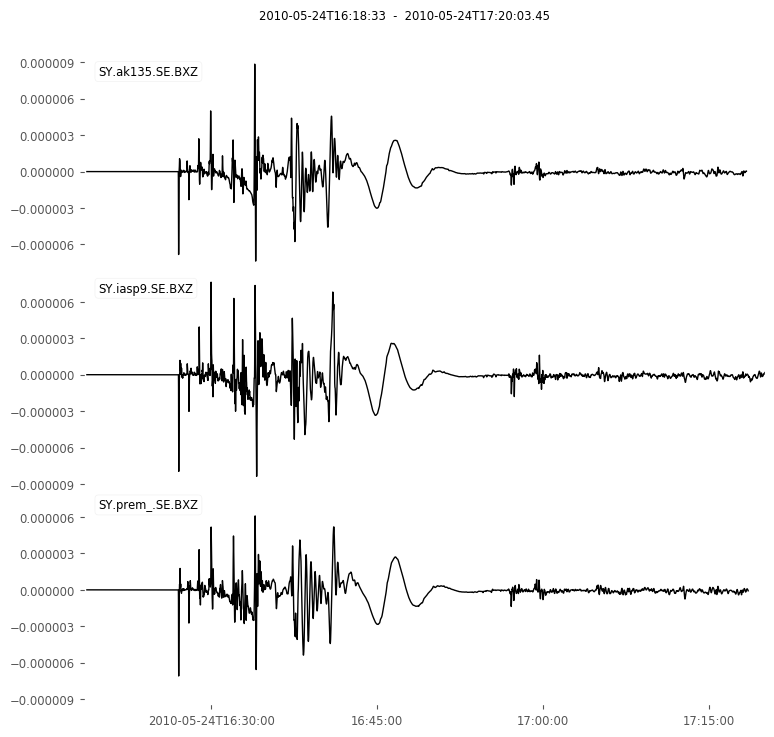

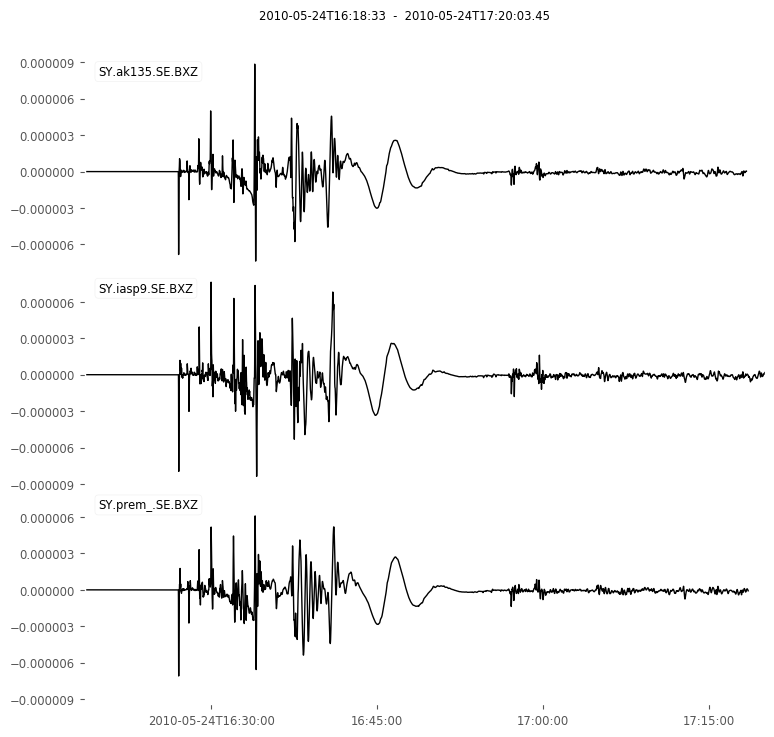

In [7]:
from obspy.clients.syngine import Client as SyngineClient
import obspy

c_s = SyngineClient()

st_synth = obspy.Stream()

for model in ["ak135f_2s", "iasp91_2s", "prem_a_2s"]:
    st_synth += c_s.get_waveforms(
        model=model, network="IU", station="ANMO",
        eventid="GCMT:C201005241618A",
        dt="0.05", units="displacement", components="Z")
    
    # Trick to make the model name show in the plots...
    st_synth[-1].stats.network = "SY"
    st_synth[-1].stats.station = model[:5]

st_synth.plot(automerge=False)

#### (Optional) Calculate Theoretical Arrival Time

In [8]:
from obspy.taup import TauPyModel

m = TauPyModel("IASP91")
arr = m.get_travel_times(
    source_depth_in_km=582.1, distance_in_degree=54.16,
    phase_list=["P"])
print(arr)

1 arrivals
	P phase arrival at 511.432 seconds


/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/obspy/taup/tau_branch.py:496: UserWarning: Resizing a TauP array inplace failed due to the existence of other references to the array, creating a new array. See Obspy #2280.
  warnings.warn(msg)


#### Plot P Arrival

In the generated plot the observed data is on the top, and the synthetic on the bottom.

1 Trace(s) in Stream:
IU.ANMO.00.BHZ | 2010-05-24T16:18:28.019538Z - 2010-05-24T17:18:27.969538Z | 20.0 Hz, 72000 samples
3 Trace(s) in Stream:
SY.ak135.SE.BXZ | 2010-05-24T16:18:33.000000Z - 2010-05-24T17:18:23.400000Z | 20.0 Hz, 71809 samples
SY.iasp9.SE.BXZ | 2010-05-24T16:18:33.000000Z - 2010-05-24T17:20:03.450000Z | 20.0 Hz, 73810 samples
SY.prem_.SE.BXZ | 2010-05-24T16:18:33.000000Z - 2010-05-24T17:18:33.150000Z | 20.0 Hz, 72004 samples


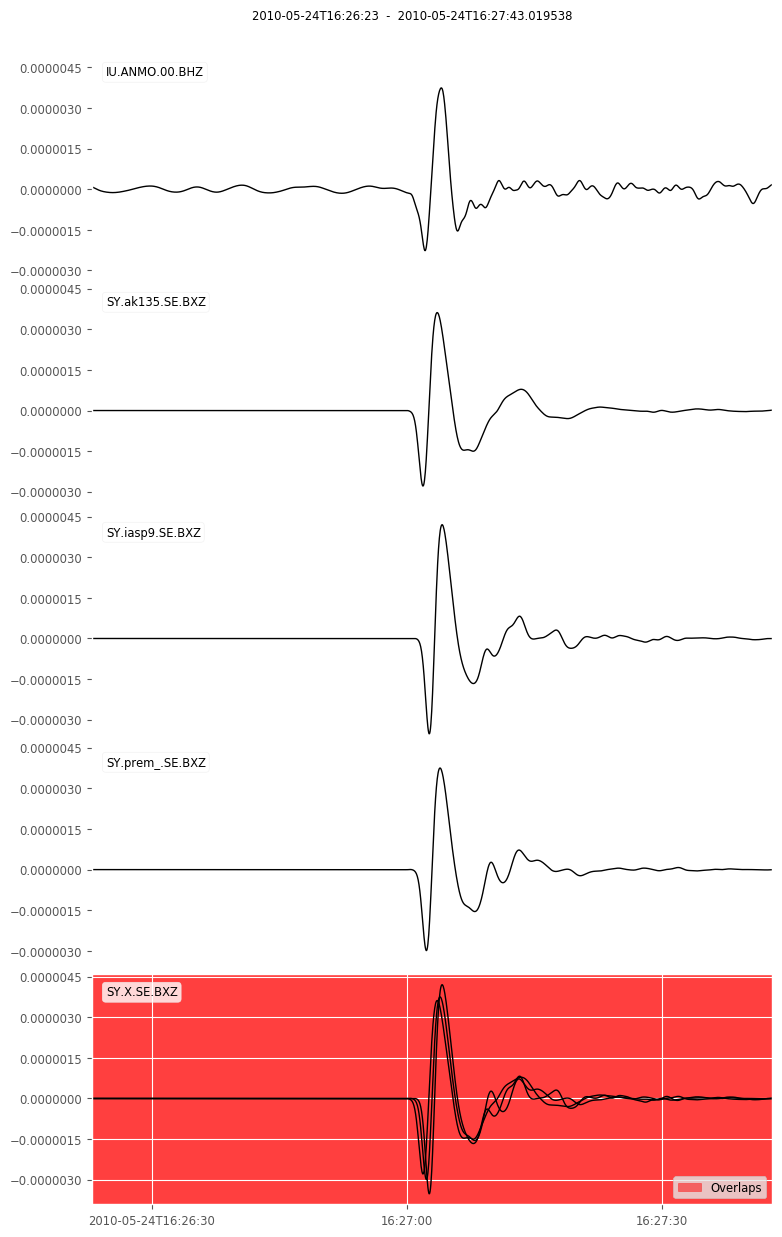

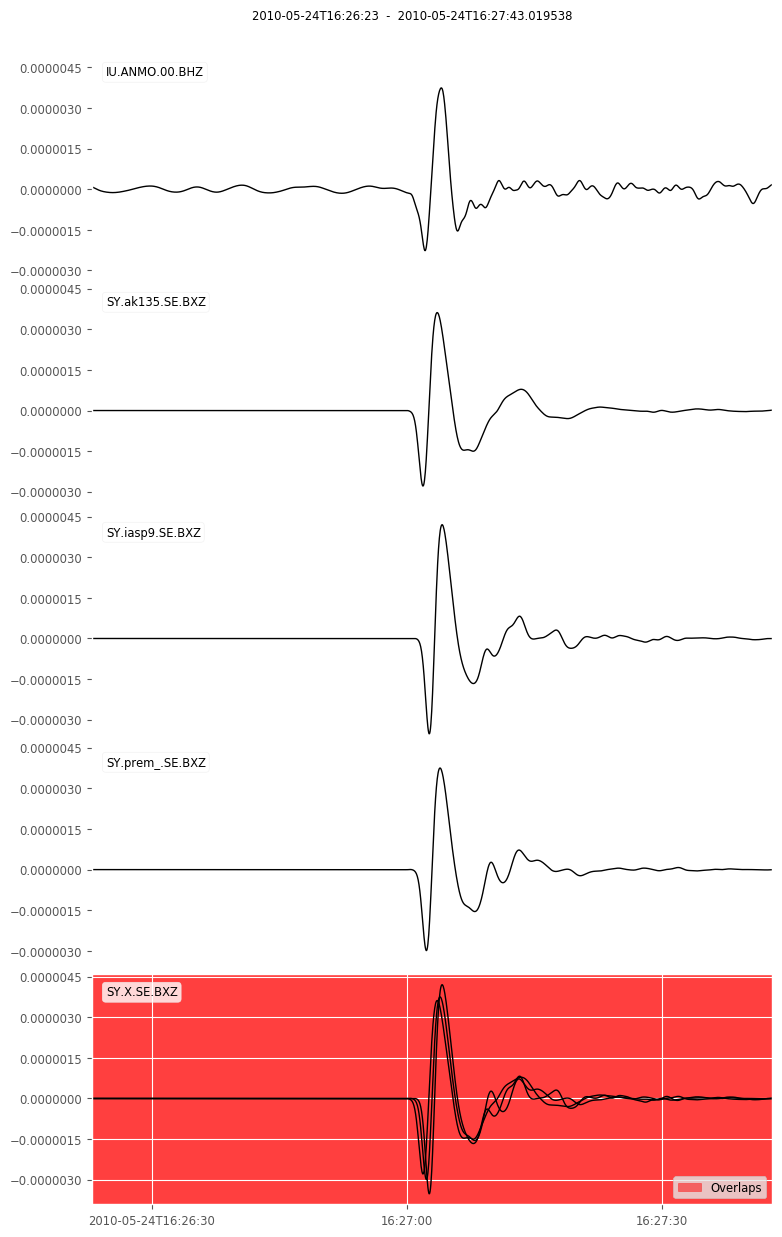

In [9]:
# Combine into a single Stream object.
st_all = st.copy() + st_synth.copy()

print(st)
print(st_synth)

# Filter to a period band from 1 to 10 seconds to highlight
# the P phase and force the same band limit on both.
st_all.detrend("demean")
st_all.taper(0.05)
st_all.filter("bandpass", freqmin=0.1, freqmax=1.0, corners=3)

# Cut window around the P arrival
starttime = st_synth[0].stats.starttime + 470
endtime = st_synth[0].stats.starttime + 550
st_all.trim(starttime, endtime)

# A couple of tricks to make ObsPy create a plot with real data,
# the three single synthetic streams, and all synthetic streams at
# once.
st_all += st_all[1:].copy()
st_all[-3].stats.station = "X"
st_all[-2].stats.station = "X"
st_all[-1].stats.station = "X"
st_all.plot()